# Partial Least Squares (PLS) regression Models

## Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Paths

In [3]:
DATA_ROOT = "./gaitrec_data"
# Train set
UNBALANCED_TRAIN_SET_METADATA_PATH = os.path.join(DATA_ROOT, "unbalanced_train_set_metadata.csv")
POSTPROCESSED_TRAIN_FOLDER = os.path.join(DATA_ROOT, 'postprocessed_train')
GROUPS_SESSIONS_DATA_TRAIN = os.path.join(DATA_ROOT, 'groups_sessions_data_train')
GRF_F_AP_PRO_DATA_TRAIN = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_train')
# Test set
TEST_SET_METADATA_PATH = os.path.join(DATA_ROOT, "test_set_metadata.csv")
TEST_FOLDER = os.path.join(DATA_ROOT, "test_set")
GROUPS_SESSIONS_DATA_TEST = os.path.join(DATA_ROOT, 'groups_sessions_data_test')
GRF_F_AP_PRO_DATA_TEST = os.path.join(DATA_ROOT, 'GRF_F_AP_PRO_data_test')

## Separar las features del target

- Separar las features (valores de la primera sesión) y el target (valores de la última sesión).
- Los valores de la primera sesión corresponden a las filas impares y los valores de la última sesión corresponden a las filas pares. 

In [4]:
def split_df_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # Select only the columns of interest
    columns_of_interest = df_train.columns[3:]  # Exclude SUBJECT_ID, SESSION_ID, TRIAL_ID
    # Create X_train, y_train, X_test, y_test:
        # Extract the odd rows into X
        # Extract the even rows into y
    X_train = df_train.iloc[::2][columns_of_interest].values
    y_train = df_train.iloc[1::2][columns_of_interest].values
    X_test = df_test.iloc[::2][columns_of_interest].values
    y_test = df_test.iloc[1::2][columns_of_interest].values

    return X_train, y_train, X_test, y_test

## Load preprocessed data
- ANKLE data - 2 sessions

In [5]:
# train df
combined_legs_2sessions_A_train = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TRAIN, 
                              'groups_2sessions_data_train/A_data/combined.csv'))
# test df
combined_legs_2sessions_A_test = pd.read_csv(os.path.join(GRF_F_AP_PRO_DATA_TEST, 
                              'groups_2sessions_data_test/A_data/combined.csv'))

## Train - Test split

In [6]:
# train - test split 
X_train_A2, y_train_A2, X_test_A2, y_test_A2 = split_df_train_test(
                                                df_train = combined_legs_2sessions_A_train, 
                                                df_test = combined_legs_2sessions_A_test)

## Model 5: Partial Least Squares (PLS) regression

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score


# Step 4: Perform hyperparameter tuning
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14, 15, 16, 17,18, 19,  20]  # Adjust the range of components to be tested
}

pls_model = PLSRegression()
grid_search = GridSearchCV(pls_model, param_grid, scoring='neg_root_mean_squared_error', cv=10) # r2
grid_search.fit(X_train_A2, y_train_A2)

best_n_components = grid_search.best_params_['n_components']
best_pls_model = grid_search.best_estimator_

In [32]:
best_n_components

9

In [21]:
best_pls_model

PLSRegression(n_components=9)

In [44]:
# Step 5: Model Evaluation with the best hyperparameters
y_pred_train_A2 = best_pls_model.predict(X_train_A2)
y_pred_test_A2 = best_pls_model.predict(X_test_A2)

In [46]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

# List to store metrics for each target variable
rmse_scores = []
correlation_coeffs = []
r2_scores = []
adjusted_r2_scores = []

# Calculate metrics for each target variable
for i in range(y_test_A2.shape[1]):  # Loop over each target variable
    y_true = y_test_A2[:, i]
    y_pred = y_pred_test_A2[:, i]
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_scores.append(rmse)
    
    # Correlation coefficient (Pearson's r)
    correlation_coeff, _ = pearsonr(y_true, y_pred)
    correlation_coeffs.append(correlation_coeff)
    
    # R-squared
    r2 = r2_score(y_true, y_pred)
    r2_scores.append(r2)
    
    # Adjusted R-squared (you need to calculate this using the formula)
    n = len(y_true)
    p = X_test_A2.shape[1]  # Number of features (101)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    adjusted_r2_scores.append(adjusted_r2)

# Calculate overall metrics
overall_rmse = np.mean(rmse_scores)
overall_correlation = np.mean(correlation_coeffs)
overall_r2 = np.mean(r2_scores)
overall_adjusted_r2 = np.mean(adjusted_r2_scores)

# Print or return the results
# print("RMSE Scores for Each Target Variable:", rmse_scores)
# print("Overall RMSE:", overall_rmse)
# print("Correlation Coefficients for Each Target Variable:", correlation_coeffs)
# print("Overall Correlation Coefficient:", overall_correlation)
# print("R-squared Scores for Each Target Variable:", r2_scores)
# print("Overall R-squared:", overall_r2)
# print("Adjusted R-squared Scores for Each Target Variable:", adjusted_r2_scores)
# print("Overall Adjusted R-squared:", overall_adjusted_r2)



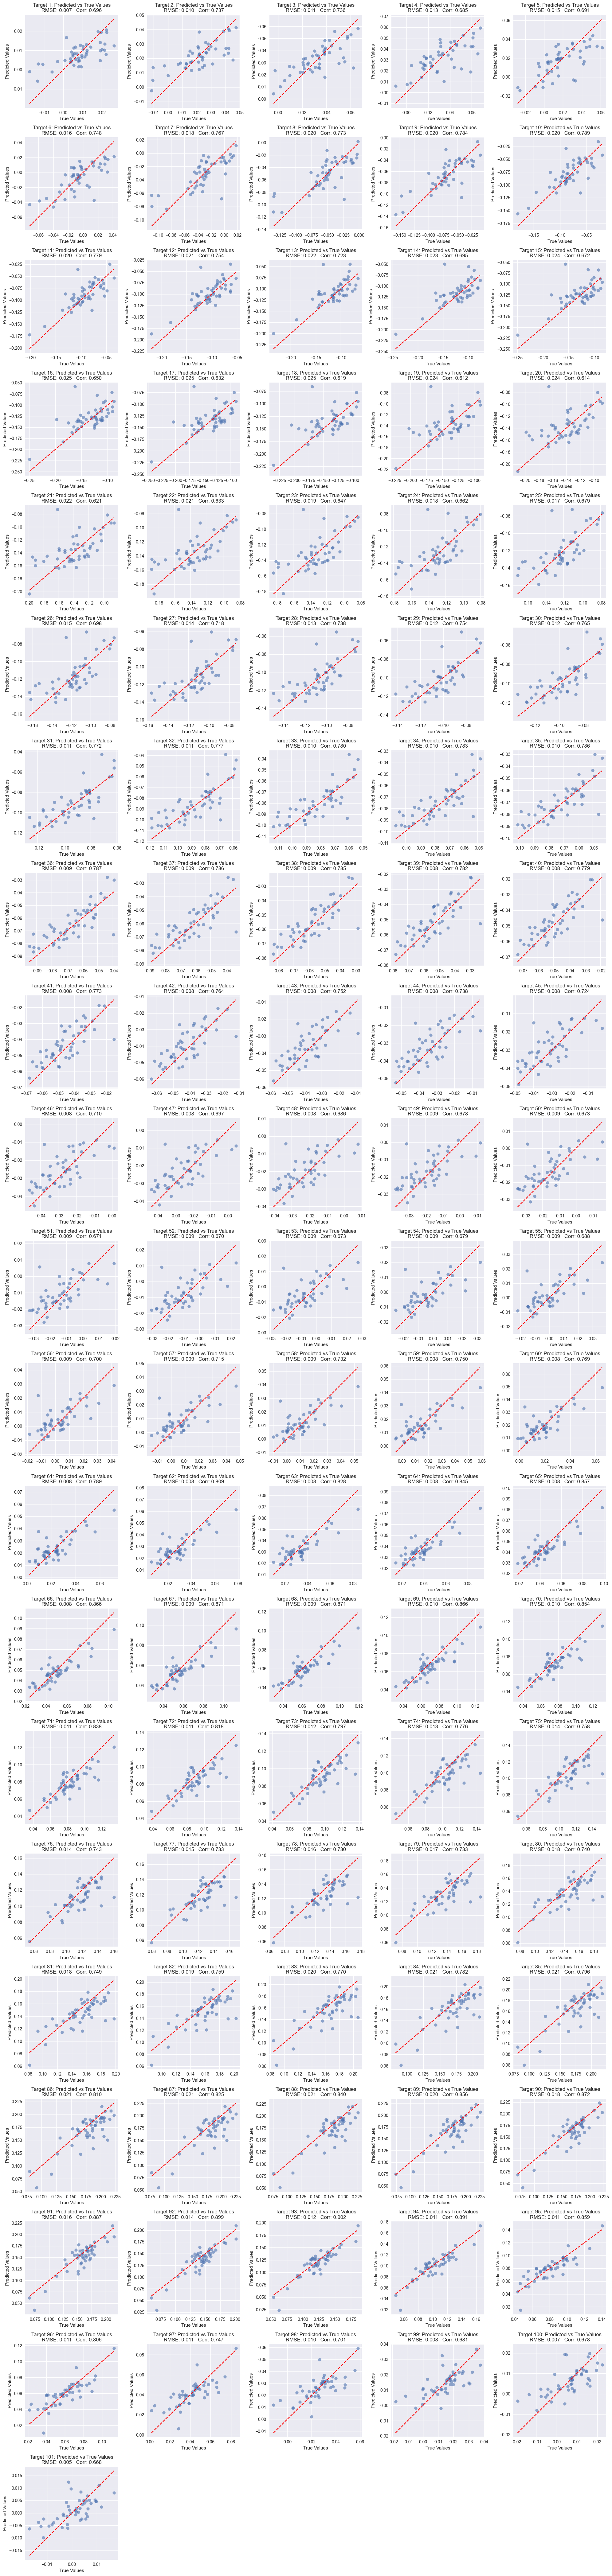

In [47]:
def plot_predictions_vs_true(y_true: np.ndarray, 
                             y_pred: np.ndarray, 
                             rmse_scores_test: list[float],
                             corr_target_test: list[float]) -> None:
    """
    Plot scatter plots of predicted values against true values for each target variable.

    Parameters:
        y_true (np.ndarray): The true target values with shape (n_samples, n_targets).
        y_pred (np.ndarray): The predicted target values with shape (n_samples, n_targets).
        rmse_scores_test (list[float]): List of RMSE scores for each target variable on the test set.
        correlations (list[float]): List of correlation coefficients for each target variable. 

    Returns:
        None
    """
    num_targets = y_true.shape[1]
    num_rows = int(np.ceil(num_targets / 5))
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    for target in range(num_targets):
        axes[target].scatter(y_true[:, target], y_pred[:, target], alpha=0.6)
        axes[target].plot([y_true[:, target].min(), y_true[:, target].max()],
                          [y_true[:, target].min(), y_true[:, target].max()],
                          color='red', linestyle='dashed')
        axes[target].set_xlabel('True Values')
        axes[target].set_ylabel('Predicted Values')
        axes[target].set_title(f"Target {target + 1}: Predicted vs True Values\nRMSE: {rmse_scores_test[target]:.3f}   Corr: {corr_target_test[target]:.3f}")

    # Hide empty subplots, if any
    for i in range(num_targets, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_predictions_vs_true(y_true=y_test_A2, 
                         y_pred=y_pred_test_A2, 
                         rmse_scores_test = rmse_scores,
                         corr_target_test = correlation_coeffs)


In [ ]:
def model_plsda(data, grupoA, grupoB, threshold):
    
    """
    Entrena un modelo de PLSDA utilizando Grid Search para encontrar los mejores hiperparámetros.
    
    Argumentos:
        data (DataFrame): DataFrame que contiene los datos del espectro RMN, donde cada fila representa
                          un espectro y las columnas son las intensidades en diferentes posiciones (ppm).
        grupoA (int): label que identifica al grupo 1
        grupoB (int): label que identifica al grupo 2
        threshold (int): umbral para determinar si una predicción hará referencia a una clase o otra
    
    Retorna:
        best_plsda_model (PLSRegression): Modelo entrenado de PLS-DA.
        y_pred_classes (array): Predicciones realizadas por el modelo sobre el conjunto de test.
        df_weights (DataFrame): DataFrame con los pesos de cada variables en cada compoenente latente (LV) en el modelo.
        weights_sorted (Serie): Media de los pesos de cada variable en las distintas componentes latentes, ordenadas de forma descendiente. 
        scores (DataFrame): DataFrame con los valores que describen la posición de cada muestra en cada variable latente
        df_vip_scores (DataFrame): DataFrame con los vipScores
        tp (int): Cantidad de verdaderos positivos en la matriz de confusión.
        fp (int): Cantidad de falsos positivos en la matriz de confusión.
        tn (int): Cantidad de verdaderos negativos en la matriz de confusión.
        fn (int): Cantidad de falsos negativos en la matriz de confusión.
    """
    
    # Separar los datos en conjuntos de train y test (70-30)
    X = data.drop(['Label', 'Sample'], axis=1)
    y = data['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
​
    # Grid search 
    num_components_range = list(range(1, 6)) 
    param_grid = {'n_components': num_components_range}
    plsda = PLSRegression()
    grid_search = GridSearchCV(plsda, param_grid, cv=5)  
    grid_search.fit(X_train, y_train)
    
    # Obtenemos el mejor modelo PLS-DA
    best_plsda_model = grid_search.best_estimator_
    # Nº de componentes latentes seleccionado por GridSearchCV
    lv= best_plsda_model.n_components
​
    # Predicciones sobre el dataset de test
    y_pred = best_plsda_model.predict(X_test)
    y_pred_classes = [grupoB if pred > threshold else grupoA for pred in y_pred]  # Convertimos las predicciones a clases binarias (0 o 1)
​
    # WEIGHTS
    weights = best_plsda_model.x_weights_
    df_weights = pd.DataFrame(np.abs(best_plsda_model.x_weights_))
    # Ordenar los weights estandarizados en orden descendente
    weights_sorted = df_weights.mean(axis=1).abs().sort_values(ascending=False)
    
    # SCORES
    scores = pd.DataFrame(best_plsda_model.x_scores_)
    if lv > 1:
        _, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(scores[0], scores[1], c=y_train, cmap='viridis')
        ax.set_xlabel('Score Component 1')
        ax.set_ylabel('Score Component 2')
        ax.set_title('PLS-DA Scores - Training Set')
​
    # VIP SCORES
    # Calcular los normalized PLS weights
    W0 = best_plsda_model.coef_ / np.sqrt(np.sum(best_plsda_model.coef_**2, axis=0))
    # Calcular los VIP scores para ncomp componentes
    p = X.shape[1]
    sumSq = np.sum(best_plsda_model.x_scores_*2, axis=0) * np.sum(y*2, axis=0)
    vipScore = np.sqrt(p * np.sum(sumSq * (W0**2), axis=1) / np.sum(sumSq))
    # Crear un DataFrame con las variables y sus VIP scores
    variable_names = X.columns  # Suponiendo que X es un DataFrame con las variables
    df_vip_scores = pd.DataFrame({'Feature': variable_names, 'VIP Score': vipScore})
    # Ordenar las variables por VIP score en orden descendente
    df_vip_scores = df_vip_scores.sort_values(by='VIP Score', ascending=False)
    # Encontrar variables con VIP score mayor o igual a 1
    indVIP = np.where(vipScore >= 1)[0]
    # Plot vip scores
    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(1, len(vipScore) + 1), vipScore, marker='x')
    plt.scatter(indVIP + 1, vipScore[indVIP], color='r', marker='x')
    plt.plot([1, len(vipScore)], [1, 1], '--k')
    plt.xlabel('Predictor Variables')
    plt.ylabel('VIP Scores')
    plt.tight_layout()
    plt.show()
    
    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(scores, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.xlabel('Componentes latentes')
    plt.ylabel('Muestras')
    plt.title('Heatmap de los Scores PLS-DA')
    plt.show()
    
    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred_classes)
    ax = sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})
    labels = np.unique(y_pred_classes)
    ax.set_xticklabels(labels[::-1], fontsize=15)
    ax.set_yticklabels(labels[::-1], fontsize=15)
    ax.set_ylabel('Expected', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set(title='PLS-DA Model')
    plt.show()
    # Calcular tp, fp, tn, fn
    tn, fp, fn, tp = cm.ravel()
    
    # Classification report
    print(classification_report(y_test, y_pred_classes))
    
​
    return best_plsda_model, y_pred_classes, df_weights, weights_sorted, scores, df_vip_scores, tp, fp, tn, fn